#First approach

In [1]:
!python -m pip install json-lines

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from typing import Callable
import torch.nn as nn
import numpy as np
import collections
import torch
import json_lines
import os
import re

from tqdm.auto import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Analysing data

In [3]:
path_to_train_data = '/content/drive/MyDrive/NLP/Homework1/data/train.jsonl'
path_to_val_data = '/content/drive/MyDrive/NLP/Homework1/data/dev.jsonl'

In [4]:
!head -5 /content/drive/MyDrive/NLP/Homework1/data/train.jsonl

{"id": "train.0", "lemma": "play", "pos": "NOUN", "sentence1": "In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.", "sentence2": "A musical play on the same subject was also staged in Kathmandu for three days.", "start1": "69", "end1": "73", "start2": "10", "end2": "14", "label": "False"}
{"id": "train.1", "lemma": "play", "pos": "NOUN", "sentence1": "In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.", "sentence2": "In schools, when water is needed, it is girls who are sent to fetch it, taking time away from their studies and play.", "start1": "69", "end1": "73", "start2": "112", "end2": "116", "label": "False"}
{"id": "train.2", "lemma": "esteem", "pos": "NOUN", "sentence1": "We would also like to convey our esteem and congratulations to fraternal Lebanon and its people on the unconditional liberation of its southern part.", "sentence2": "Father L

In [5]:
# Simple initial preprocessing (not used anymore)
def preprocess_sentence_initial(sentence: str) -> str:
  sentence = sentence.lower()
  sentence = re.sub(r"what's", "what is", sentence)   # replace contracted form
  sentence = re.sub("\'s", "", sentence)              # remove 's at the end of words
  sentence = re.sub(r"\'ve", " have", sentence)       # replace contracted form
  sentence = re.sub(r"can't", "cannot", sentence)     # replace contracted form
  sentence = re.sub(r"\n't", " not", sentence)        # replace contracted form
  sentence = re.sub(r"i'm", "i am", sentence)         # replace contracted form
  sentence = re.sub(r"\'re", " are", sentence)        # replace contracted form
  sentence = re.sub(r"\'d", " would", sentence)       # replace contracted form
  sentence = re.sub(r"\'ll", " will", sentence)       # replace contracted form
  sentence = re.sub(r"[^A-Za-z]", " ", sentence)      # remove characters different from alphabetic letters
  sentence = re.sub(r" {1,}", " ", sentence)          # remove repeated spaces

  return sentence

In [29]:
# Preprocess each input sentence
def preprocess_sentence(sentence: str) -> str:

  sentence = sentence.lower()
    
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(sentence)

  tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words("english")]

  return sentence

The following function analyse the dataset that is given as input, returning a dictionary containing all the words and the corresponding number of occurrences. This function is then used on both the training and validation sets to study how words are distributed between them. Clearly, the first thing we can notice is that since the validation set contains less samples, so less pairs of sentences, the number of distinct words is less than in the trianing set, but we expected that. In the same way, since the training set contains just 5000 samples, the number of distinct words is relatively small, and this why we decided to use pretrained embeddings, that are trained on large corpora, 
and therefore are more likely to give better results.



In [6]:
def analyse_dataset(data_path:str):
  counter_list = []

  with open(data_path) as f:
    for line in json_lines.reader(f):
      tokens1 = word_tokenize(preprocess_sentence_initial(line['sentence1']))
      tokens2 = word_tokenize(preprocess_sentence_initial(line['sentence2']))
      counter_list.extend(tokens1)
      counter_list.extend(tokens2)

  counter = collections.Counter(counter_list)
  counter_len = len(counter)

  dictionary = {key: index for index, key in enumerate(counter)}
  dict_counts = {x: counter[x] for x in dictionary}

  return dict_counts

In [7]:
train_dict_counts = analyse_dataset(path_to_train_data)
val_dict_counts = analyse_dataset(path_to_val_data)

print("Number of distinct words in the training set: {}".format(len(train_dict_counts)))
print("Number of distinct words in the validation set: {}".format(len(val_dict_counts)))

Number of distinct words in the training set: 26395
Number of distinct words in the validation set: 7879


Using the dictionaries that we have just built, we create a new dictionary in which we have as keys all the words and as values we have lists of two integers, which represent respectively the number of occurrences in the training and validation sets. Using this dictionary, we count how many times we encounter words in the validation set that never appear, how many of them appear just once, less than 5 times and so on in the training set. Showing the results in a plot, we see that 1/4 of the words in the validation set occur less than 20 times in the training set.

In [8]:
all_words = dict()
for key in (set(train_dict_counts.keys()) | set(val_dict_counts.keys())):
  values = list()
  if key in train_dict_counts:
    values.append(train_dict_counts[key])
  else:
    values.append(0)
  
  if key in val_dict_counts:
    values.append(val_dict_counts[key])
  else:
    values.append(0)
    
  all_words[key] = values

In [9]:
occurrences = np.zeros(9, dtype=int)
for key, pair in all_words.items():
  if pair[0] == 0:
    occurrences[0] += pair[1]
  if pair[0] == 1 and pair[1] != 0:
    occurrences[1] += pair[1]
  if pair[0] <= 5 and pair[0] > 1 and pair[1] != 0:
    occurrences[2] += pair[1]
  if pair[0] <= 10 and pair[0] > 5 and pair[1] != 0:
    occurrences[3] += pair[1]
  if pair[0] <= 20 and pair[0] > 10 and pair[1] != 0:
    occurrences[4] += pair[1]
  if pair[0] <= 30 and pair[0] > 20 and pair[1] != 0:
    occurrences[5] += pair[1]
  if pair[0] <= 40 and pair[0] > 30 and pair[1] != 0:
    occurrences[6] += pair[1]
  if pair[0] <= 50 and pair[0] > 40 and pair[1] != 0:
    occurrences[7] += pair[1]
  if pair[0] > 50 and pair[1] != 0:
    occurrences[8] += pair[1]

In [10]:
print(f"Number of words in the validation set that never occur in the training set {occurrences[0]}")
print(f"Number of words in the validation set that occur just once in the training set {occurrences[1]}")
print(f"Number of words in the validation set that occur between 1 and 5 (included) times in the training set {occurrences[2]}")
print(f"Number of words in the validation set that occur between 5 and 10 (included) times in the training set {occurrences[3]}")
print(f"Number of words in the validation set that occur between 10 and 20 (included) times in the training set {occurrences[4]}")
print(f"Number of words in the validation set that occur between 20 and 30 (included) times in the training set {occurrences[5]}")
print(f"Number of words in the validation set that occur between 30 and 40 (included) times in the training set {occurrences[6]}")
print(f"Number of words in the validation set that occur between 40 and 50 (included) times in the training set {occurrences[7]}")
print(f"Number of words in the validation set that occur more than 50 times in the training set {occurrences[8]}")

Number of words in the validation set that never occur in the training set 2580
Number of words in the validation set that occur just once in the training set 948
Number of words in the validation set that occur between 1 and 5 (included) times in the training set 2651
Number of words in the validation set that occur between 5 and 10 (included) times in the training set 2267
Number of words in the validation set that occur between 10 and 20 (included) times in the training set 2934
Number of words in the validation set that occur between 20 and 30 (included) times in the training set 2022
Number of words in the validation set that occur between 30 and 40 (included) times in the training set 1698
Number of words in the validation set that occur between 40 and 50 (included) times in the training set 1261
Number of words in the validation set that occur more than 50 times in the training set 29162


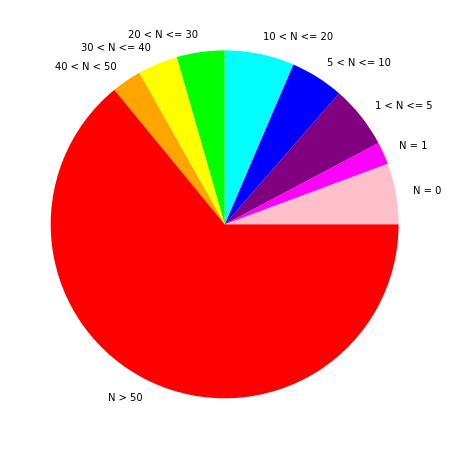

In [11]:
label = ["N = 0", "N = 1", "1 < N <= 5", "5 < N <= 10", "10 < N <= 20", "20 < N <= 30", "30 < N <= 40", "40 < N < 50", "N > 50"]

plt.figure(figsize=(8,8))
plt.pie(occurrences, labels=label, colors=['pink', 'magenta', 'purple', 'blue', 'cyan', 'lime', 'yellow', 'orange', 'red'], labeldistance=1.1)
plt.show()

## Glove and Word2vec pre-trained embeddings

In [ ]:
! head /content/drive/MyDrive/NLP/Homework1/glove.6B.300d.txt

In [ ]:
! head /content/drive/MyDrive/NLP/Homework1/GoogleNews-vectors-negative300.txt

In [ ]:
# build a dictionary with GloVe word embeddings using all the words that it contains
glove_dict = dict()
max_words = 400000

with open('/content/drive/MyDrive/NLP/Homework1/glove.6B.300d.txt') as f:
  for i, line in tqdm(enumerate(f), total=max_words):
    if i == max_words:
      break

    word, *vector = line.strip().split(' ')
    vector = torch.tensor([float(n) for n in vector])

    glove_dict[word] = vector

In [ ]:
# build a dictionary with Word2Vec word embeddings using all the words that it contains
word2vec_dict = dict()
max_words = 3000000

with open('/content/drive/MyDrive/NLP/Homework1/GoogleNews-vectors-negative300.txt') as f:
  next(f)
  for i, line in tqdm(enumerate(f), total=max_words):
    if i == max_words:
      break

    word, *vector = line.strip().split(' ')
    word = word.lower()
    vector = torch.tensor([float(n) for n in vector])

    word2vec_dict[word] = vector

In [ ]:
# Build a dictionary with all the words that are present in both GloVe and Word2Vec
# that have as associated word vectors the concatenation of the GloVe and Word2Vec
# word embeddings
glove_w2v_dict = dict()
keys = glove_dict.keys() & word2vec_dict.keys()

for key in keys:
  glove_w2v_dict[key] = torch.cat((glove_dict[key], word2vec_dict[key]), 0)

In [ ]:
# For efficiency reasons, we reduce the size of the GloVe and Word2Vec dictionaries,
# by considering the words that are present in both of them, that are likely the most
# frequent ones
glove_dict = {key: glove_dict[key] for key in keys}
word2vec_dict = {key: word2vec_dict[key] for key in keys}

In [ ]:
# save the dictionaries
np.save('/content/drive/MyDrive/NLP/Homework1/glove_dictionary.npy', glove_dict)
np.save('/content/drive/MyDrive/NLP/Homework1/word2vec_dictionary.npy', word2vec_dict)
np.save('/content/drive/MyDrive/NLP/Homework1/glove_w2v_dictionary.npy', glove_w2v_dict)

In [32]:
# load the dictionaries
glove_dict = np.load('/content/drive/MyDrive/NLP/Homework1/glove_dictionary.npy', allow_pickle='TRUE').item()
word2vec_dict = np.load('/content/drive/MyDrive/NLP/Homework1/word2vec_dictionary.npy', allow_pickle='TRUE').item()
glove_w2v_dict = np.load('/content/drive/MyDrive/NLP/Homework1/glove_w2v_dictionary.npy', allow_pickle='TRUE').item()

In [55]:
print(len(glove_dict))
print(len(word2vec_dict))
print(len(glove_w2v_dict))

284859
284859
284859


## Building the dataset

In [33]:
# Build the vector representation that is given as input to our model, by taking the word embeddings for each token in each of the two sentences,
# considering just the words that are in the dictionary and that are not stopwords, computing their means, and concatenating them.
# With two flags, glove and mixed, we handle the use of the 3 different dictionaries. In the case of the combined word embeddings, we first concatenate
# the word embeddings of the two sentences and then we compute the mean of their concatenation, so that in all 3 cases we have a 600-dimensional vector.

def sentence2vec(sentence1:str, sentence2: str, glove: bool, mixed: bool):
  if mixed:
    sentence_vector1 = [glove_w2v_dict[word] for word in word_tokenize(sentence1) if word in glove_w2v_dict and word not in stopwords.words('english')]
    sentence_vector2 = [glove_w2v_dict[word] for word in word_tokenize(sentence2) if word in glove_w2v_dict and word not in stopwords.words('english')]

    if len(sentence_vector1) == 0 or  len(sentence_vector2) == 0:
      return None

    sentence_vector = sentence_vector1 + sentence_vector2
    sentence_vector = torch.stack(sentence_vector)

    return torch.mean(sentence_vector, dim=0)

  else:
    if glove:
      sentence_vector1 = [glove_dict[word] for word in word_tokenize(sentence1) if word in glove_dict and word not in stopwords.words('english')]
      sentence_vector2 = [glove_dict[word] for word in word_tokenize(sentence2) if word in glove_dict and word not in stopwords.words('english')]

    else:
      sentence_vector1 = [word2vec_dict[word] for word in word_tokenize(sentence1) if word in word2vec_dict and word not in stopwords.words('english')]
      sentence_vector2 = [word2vec_dict[word] for word in word_tokenize(sentence2) if word in word2vec_dict and word not in stopwords.words('english')]

    if len(sentence_vector1) == 0 or  len(sentence_vector2) == 0:
      return None

    sentence_vector1 = torch.stack(sentence_vector1)
    sentence_vector2 = torch.stack(sentence_vector2)

    mean1 = torch.mean(sentence_vector1, dim=0)
    mean2 = torch.mean(sentence_vector2, dim=0)

    return torch.cat((mean1, mean2), 0)

In [34]:
class WordInContextDataset(Dataset):
  
  def __init__(self, data_path, sentence2vec, glove=True, mixed=False):
    self.data = []
    self.glove = glove
    self.mixed = mixed
    self.create_samples(data_path, sentence2vec)

  def create_samples(self, data_path, sentence2vec):

    with open(data_path) as f:
      for line in json_lines.reader(f):
        sentence1 = preprocess_sentence(line['sentence1'])
        sentence2 = preprocess_sentence(line['sentence2'])

        sentence_vector = sentence2vec(sentence1, sentence2, glove=self.glove, mixed=self.mixed)

        if sentence_vector is None:
          continue

        label = line['label']
        if label == 'True':
          label = 1.0
        else:
          label = 0.0
        
        self.data.append((sentence_vector, label))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [35]:
# create dataset using GloVe word embeddings
train_dataset_glove = WordInContextDataset(path_to_train_data, sentence2vec)
val_dataset_glove = WordInContextDataset(path_to_val_data, sentence2vec)

train_dataloader_glove = DataLoader(train_dataset_glove, batch_size=16)
val_dataloader_glove = DataLoader(val_dataset_glove, batch_size=16)

In [36]:
# create dataset using Word2Vec word embeddings
train_dataset_w2v = WordInContextDataset(path_to_train_data, sentence2vec, glove = False)
val_dataset_w2v = WordInContextDataset(path_to_val_data, sentence2vec, glove = False)

train_dataloader_w2v = DataLoader(train_dataset_w2v, batch_size=16)
val_dataloader_w2v = DataLoader(val_dataset_w2v, batch_size=16)

In [37]:
# create dataset using GloVe and Word2Vec word embeddings
train_dataset_mixed = WordInContextDataset(path_to_train_data, sentence2vec, mixed=True)
val_dataset_mixed = WordInContextDataset(path_to_val_data, sentence2vec, mixed=True)

train_dataloader_mixed = DataLoader(train_dataset_mixed, batch_size=16)
val_dataloader_mixed = DataLoader(val_dataset_mixed, batch_size=16)

## Building the classifier

In [38]:
class Classifier(nn.Module):
  def __init__(self, input_features, hidden_size, output_classes):
    super().__init__()
    self.global_epoch = 0

    self.lin1 = nn.Linear(input_features, hidden_size)
    self.lin2 = nn.Linear(hidden_size, output_classes)

    self.prelu = nn.PReLU()
    self.loss_fn = nn.BCELoss()

  def forward(self, x, y=None):
    out = self.lin1(x)
    out = self.prelu(out)
    out = self.lin2(out).squeeze(1)
    out = torch.sigmoid(out)

    result = {'pred': out}

    if y is not None:
      loss = self.loss(out, y.float())
      result['loss'] = loss

    return result
  
  def loss(self, pred, y):
    return self.loss_fn(pred, y)

In [39]:
def evaluate_model(model: nn.Module, dataloader: DataLoader):
  losses = []
  predictions = []
  labels = []
  n = 0
  d = 0

  for x, y in dataloader:
    outputs = model(x,y)
    loss = outputs['loss']
    losses.append(loss)
    pred = outputs['pred']
    pred = torch.round(pred)
    predictions.append(pred)
    labels.append(y)

    d += pred.shape[0]
    n += (y == pred).int().sum()
    
  mean_loss = sum(losses) / len(losses)
  mean_accuracy = (n / d).item()

  return {'loss': mean_loss, 'accuracy': mean_accuracy}

In [40]:
def train_and_evaluate(model: nn.Module, optimizer: torch.optim.Optimizer, 
                       train_dataloader: DataLoader, epochs: int = 5,
                       valid_dataloader: DataLoader = None, valid_fn: Callable = None,
                       verbose: bool = True):
  train_acc = []
  train_loss = []
  val_acc = []
  val_loss = []

  min_val_loss = np.Inf 
  stop_epochs = 5
  no_improvement = 0

  for epoch in range(epochs):
    losses = []
    predictions = []
    labels = []
    n = 0
    d = 0

    # batches of the training set
    for x, y in train_dataloader:
      optimizer.zero_grad()
      batch_out = model(x, y)
      loss = batch_out['loss']
      losses.append(loss)
      pred = batch_out['pred']
      pred = torch.round(pred)
      predictions.append(pred)
      labels.append(y)

      d += pred.shape[0]
      n += (y == pred).int().sum()

      # computes the gradient of the loss
      loss.backward()
      # update parameters based on the gradient information
      optimizer.step()

    model.global_epoch += 1
    mean_loss = sum(losses) / len(losses)
    mean_accuracy = (n / d).item()

    train_loss.append(mean_loss.item())
    train_acc.append(mean_accuracy)

    if verbose or epoch == epochs - 1:
      print(f' Epoch {model.global_epoch:3d} => Loss: {mean_loss:0.6f} | Accuracy: {mean_accuracy:0.2f}')
    
    if verbose and valid_dataloader:
      assert valid_fn is not None
      valid_output = valid_fn(model, valid_dataloader)
      valid_loss = valid_output['loss']
      valid_accuracy = valid_output['accuracy']
      val_loss.append(valid_loss.item())
      val_acc.append(valid_accuracy)
      print(f' Validation loss: {valid_loss:0.6f}, Validation accuracy: {valid_accuracy:0.2f}')
      print()

    # EARLY STOPPING: 
    # - If the valid loss is less or equal than the minimum loss obtained until now we set
    #   no_improvement=0 and we update min_val_loss to the current value.
    # - Otherwise we increase no_improvement by 1.
    # When no_improvement is equal to stop_epochs, we stop the training.
    
    if valid_loss <= min_val_loss:
      no_improvement = 0
      min_val_loss = valid_loss
    else:
      no_improvement += 1

    if no_improvement == stop_epochs:
      print('Early stopping!')
      break
    else:
      continue

  return {'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss': val_loss}

## Training the model with Glove

In [41]:
glove_model = Classifier(input_features=600, hidden_size=64, output_classes=1)
optimizer = torch.optim.Adam(glove_model.parameters(), lr=0.0002, betas=(0.85, 0.999))

glove_logs = train_and_evaluate(model=glove_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_glove,
                          valid_dataloader=val_dataloader_glove,
                          valid_fn=evaluate_model,
                          epochs=50)

 Epoch   1 => Loss: 0.693476 | Accuracy: 0.51
 Validation loss: 0.686548, Validation accuracy: 0.59

 Epoch   2 => Loss: 0.686790 | Accuracy: 0.55
 Validation loss: 0.680285, Validation accuracy: 0.59

 Epoch   3 => Loss: 0.679401 | Accuracy: 0.57
 Validation loss: 0.674067, Validation accuracy: 0.59

 Epoch   4 => Loss: 0.670430 | Accuracy: 0.59
 Validation loss: 0.667216, Validation accuracy: 0.60

 Epoch   5 => Loss: 0.659876 | Accuracy: 0.61
 Validation loss: 0.659464, Validation accuracy: 0.63

 Epoch   6 => Loss: 0.647871 | Accuracy: 0.63
 Validation loss: 0.651026, Validation accuracy: 0.63

 Epoch   7 => Loss: 0.634344 | Accuracy: 0.65
 Validation loss: 0.641938, Validation accuracy: 0.64

 Epoch   8 => Loss: 0.619719 | Accuracy: 0.67
 Validation loss: 0.632686, Validation accuracy: 0.64

 Epoch   9 => Loss: 0.604534 | Accuracy: 0.69
 Validation loss: 0.624172, Validation accuracy: 0.65

 Epoch  10 => Loss: 0.589093 | Accuracy: 0.70
 Validation loss: 0.616539, Validation accura

In [42]:
OUTPUT_PATH = '/content/drive/MyDrive/NLP/Homework1/models/pretrained_glove_69_1.pth'
#torch.save(glove_model.state_dict(), OUTPUT_PATH)

## Training the model using Word2Vec pretrained embeddings

In [43]:
w2v_model = Classifier(input_features=600, hidden_size=64, output_classes=1)
optimizer = torch.optim.Adam(w2v_model.parameters(), lr=0.0002, betas=(0.85, 0.999))

w2v_logs = train_and_evaluate(model=w2v_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_w2v,
                          valid_dataloader=val_dataloader_w2v,
                          valid_fn=evaluate_model,
                          epochs=50)

 Epoch   1 => Loss: 0.694420 | Accuracy: 0.51
 Validation loss: 0.692767, Validation accuracy: 0.50

 Epoch   2 => Loss: 0.693563 | Accuracy: 0.51
 Validation loss: 0.692291, Validation accuracy: 0.52

 Epoch   3 => Loss: 0.692854 | Accuracy: 0.52
 Validation loss: 0.691763, Validation accuracy: 0.54

 Epoch   4 => Loss: 0.692102 | Accuracy: 0.53
 Validation loss: 0.691284, Validation accuracy: 0.55

 Epoch   5 => Loss: 0.691320 | Accuracy: 0.53
 Validation loss: 0.690768, Validation accuracy: 0.54

 Epoch   6 => Loss: 0.690452 | Accuracy: 0.54
 Validation loss: 0.690320, Validation accuracy: 0.54

 Epoch   7 => Loss: 0.689564 | Accuracy: 0.54
 Validation loss: 0.689880, Validation accuracy: 0.54

 Epoch   8 => Loss: 0.688578 | Accuracy: 0.54
 Validation loss: 0.689496, Validation accuracy: 0.53

 Epoch   9 => Loss: 0.687462 | Accuracy: 0.54
 Validation loss: 0.689188, Validation accuracy: 0.52

 Epoch  10 => Loss: 0.686092 | Accuracy: 0.54
 Validation loss: 0.688972, Validation accura

In [44]:
#OUTPUT_PATH = '/content/drive/MyDrive/NLP/Homework1/models/pretrained_w2v.pth'
#torch.save(w2v_model.state_dict(), OUTPUT_PATH)

## Training the model using Glove and Word2Vec pretrained embeddings

In [45]:
mixed_model = Classifier(input_features=600, hidden_size=64, output_classes=1)
optimizer = torch.optim.Adam(mixed_model.parameters(), lr=0.0002, betas=(0.85, 0.999))

mixed_logs = train_and_evaluate(model=mixed_model, optimizer=optimizer,
                          train_dataloader=train_dataloader_mixed,
                          valid_dataloader=val_dataloader_mixed,
                          valid_fn=evaluate_model,
                          epochs=50)

 Epoch   1 => Loss: 0.693865 | Accuracy: 0.51
 Validation loss: 0.689736, Validation accuracy: 0.57

 Epoch   2 => Loss: 0.691422 | Accuracy: 0.53
 Validation loss: 0.687021, Validation accuracy: 0.57

 Epoch   3 => Loss: 0.689158 | Accuracy: 0.54
 Validation loss: 0.684407, Validation accuracy: 0.57

 Epoch   4 => Loss: 0.686622 | Accuracy: 0.55
 Validation loss: 0.682226, Validation accuracy: 0.57

 Epoch   5 => Loss: 0.683691 | Accuracy: 0.56
 Validation loss: 0.680014, Validation accuracy: 0.57

 Epoch   6 => Loss: 0.680414 | Accuracy: 0.58
 Validation loss: 0.677737, Validation accuracy: 0.58

 Epoch   7 => Loss: 0.676818 | Accuracy: 0.59
 Validation loss: 0.675380, Validation accuracy: 0.59

 Epoch   8 => Loss: 0.673093 | Accuracy: 0.59
 Validation loss: 0.673128, Validation accuracy: 0.59

 Epoch   9 => Loss: 0.669190 | Accuracy: 0.60
 Validation loss: 0.670920, Validation accuracy: 0.60

 Epoch  10 => Loss: 0.665207 | Accuracy: 0.60
 Validation loss: 0.668890, Validation accura

In [46]:
#OUTPUT_PATH = '/content/drive/MyDrive/NLP/Homework1/models/pretrained_mixed.pth'
#torch.save(mixed_model.state_dict(), OUTPUT_PATH)

## Evaluating the models

In [47]:
def overall_validation_performance(model, val_dataloader):
  n = 0
  d = 0

  for x, y in val_dataloader:
    with torch.no_grad():
      batch_out = model(x)
      pred = batch_out['pred']

    pred = torch.round(pred)
    d += pred.shape[0]
    n += (y == pred).int().sum()

  print(f'# accuracy: {(n / d).item():.2f}')

In [48]:
def plot_metrics(logs):
  plt.figure(figsize=(15,3))
  plt.subplot(1, 2, 1)
  plt.plot(logs['train_acc'],'-')
  plt.plot(logs['val_acc'],'-')
  plt.xlabel('epoch', fontsize=14)
  plt.ylabel('accuracy', fontsize=14)
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Accuracy', fontsize=16)

  plt.subplot(1, 2, 2)
  plt.plot(logs['train_loss'],'-')
  plt.plot(logs['val_loss'],'-')
  plt.xlabel('epoch', fontsize=14)
  plt.ylabel('loss', fontsize=14)
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Loss', fontsize=16)

### Glove

In [63]:
overall_validation_performance(glove_model, val_dataloader_glove)

# accuracy: 0.67


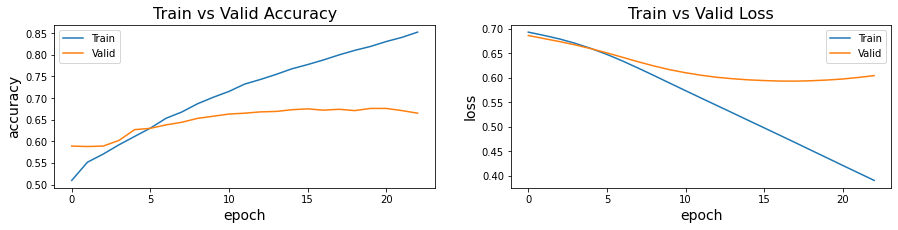

In [50]:
plot_metrics(glove_logs)

### Word2Vec

In [51]:
overall_validation_performance(w2v_model, val_dataloader_w2v)

# accuracy: 0.53


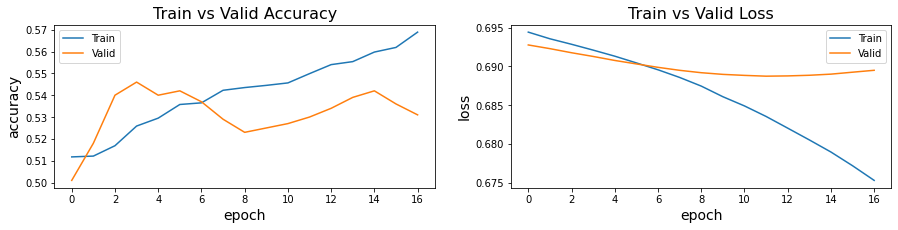

In [52]:
plot_metrics(w2v_logs)

### Glove and Word2Vec

In [53]:
overall_validation_performance(mixed_model, val_dataloader_mixed)

# accuracy: 0.63


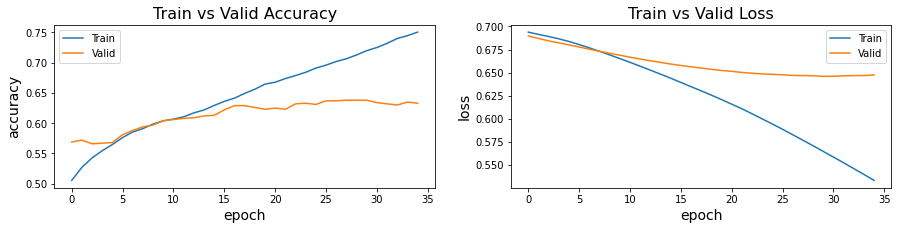

In [54]:
plot_metrics(mixed_logs)